In [13]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer

In [57]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [102]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Cart Pole Environment</h2>

In [103]:
env_id = "CartPole-v0"
env = gym.make(env_id)

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


<h2>Distributional Reinforcement Learning with Quantile Regression</h2>

In [104]:
class QRDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_quants):
        super(QRDQN, self).__init__()
        
        self.num_inputs  = num_inputs
        self.num_actions = num_actions
        self.num_quants  = num_quants
        
        self.features = nn.Sequential(
            nn.Linear(num_inputs, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions * self.num_quants)
        )
        
        #self.noisy_value1 = NoisyLinear(64, 128, use_cuda=USE_CUDA)
        #self.noisy_value2 = NoisyLinear(128, self.num_actions * self.num_quants, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)

        x = self.features(x)
        
        #x = self.noisy_value1(x)
        #x = F.relu(x)
        #x = self.noisy_value2(x)
        x = x.view(batch_size, self.num_actions, self.num_quants)
        
        return x
    
    def q_values(self, x):
        x = self.forward(x)
        return x.mean(2)
    
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise() 
        
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = Variable(torch.FloatTensor(np.array(state, dtype=np.float32)).unsqueeze(0), volatile=True)
            qvalues = self.forward(state).mean(2)
            action  = qvalues.max(1)[1]
            action  = action.data.cpu().numpy()[0]
        else:
            action = random.randrange(self.num_actions)
        return action

In [105]:
def projection_distribution(dist, next_state, reward, done):
    next_dist = target_model(next_state)
    next_action = next_dist.mean(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_quant)
    next_dist = next_dist.gather(1, next_action).squeeze(1).cpu().data

    expected_quant = reward.unsqueeze(1) + 0.99 * next_dist * (1 - done.unsqueeze(1))
    expected_quant = Variable(expected_quant)

    quant_idx = torch.sort(dist, 1, descending=False)[1]

    tau_hat = torch.linspace(0.0, 1.0 - 1./num_quant, num_quant) + 0.5 / num_quant
    tau_hat = tau_hat.unsqueeze(0).repeat(batch_size, 1)
    quant_idx = quant_idx.cpu().data
    batch_idx = np.arange(batch_size)
    tau = tau_hat[:, quant_idx][batch_idx, batch_idx]
        
    return tau, expected_quant

In [106]:
num_quant = 51
Vmin = -10
Vmax = 10

current_model = QRDQN(env.observation_space.shape[0], env.action_space.n, num_quant)
target_model  = QRDQN(env.observation_space.shape[0], env.action_space.n, num_quant)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(10000)

In [107]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [119]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_quant)
    dist = dist.gather(1, action).squeeze(1)
    
    tau, expected_quant = projection_distribution(dist, next_state, reward, done)
    k = 1
    
    huber_loss = 0.5 * u.abs().clamp(min=0.0, max=k).pow(2)
    huber_loss += k * (u.abs() -  u.abs().clamp(min=0.0, max=k))
    quantile_loss = (tau - (u < 0).float()).abs() * huber_loss
    loss = quantile_loss.sum() / num_quant
        
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm(current_model.parameters(), 0.5)
    optimizer.step()
    
    return loss

In [109]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

In [110]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [111]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

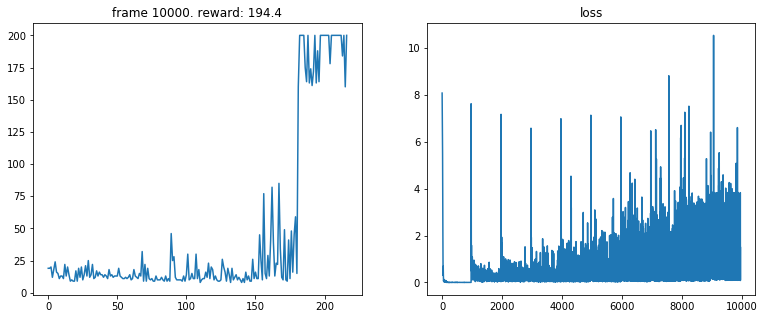

In [112]:
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state, epsilon_by_frame(frame_idx))
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)

<p><hr></p>

<h1>Atari Environment</h1>

In [120]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [121]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [122]:
class QRCnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions, num_quants):
        super(QRCnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.num_quants  = num_quants
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.value = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions * self.num_quants)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = self.features(x)
        x = x.view(batch_size, -1)
        
        x = self.value(x)
        x = x.view(batch_size, self.num_actions, self.num_quants)
        
        return x
    
    def q_values(self, x):
        x = self.forward(x)
        return x.mean(2)
        
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
        
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = Variable(torch.FloatTensor(np.array(state, dtype=np.float32)).unsqueeze(0), volatile=True)
            qvalues = self.forward(state).mean(2)
            action  = qvalues.max(1)[1]
            action  = action.data.cpu().numpy()[0]
        else:
            action = random.randrange(self.num_actions)
        return action

In [123]:
num_quant = 51
Vmin = -10
Vmax = 10

current_model = QRCnnDQN(env.observation_space.shape, env.action_space.n, num_quant)
target_model  = QRCnnDQN(env.observation_space.shape, env.action_space.n, num_quant)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
update_target(current_model, target_model)
    
optimizer = optim.Adam(current_model.parameters(), lr=5e-5)

replay_initial = 10000
replay_buffer  = ReplayBuffer(100000)

In [124]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [ ]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state, epsilon_by_frame(frame_idx))
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)